In [1]:
import json
import os
from pathlib import Path
import time
from typing import Any, Dict, List, Optional

# from IPython.display import Image, display
import jsonlines
import pandas as pd
from pydantic import BaseModel
from tqdm import tqdm

from config import settings

os.environ["HF_HOME"] = settings.docling_model_weight_dir

In [2]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [3]:
import sys

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
core_src_dir = os.path.join(parent_dir, "src/psiking")
sys.path.append(core_src_dir)

In [4]:
## Import Core Schemas
from core.base.schema import Document, TextNode, ImageNode, TableNode

# 1. Prepare Docling reader
* test image description option
    * https://github.com/DS4SD/docling/blob/main/docs/examples/pictures_description_api.py
## PictureDescription Options
[Reference](https://ds4sd.github.io/docling/reference/pipeline_options/#docling.datamodel.pipeline_options.PictureDescriptionApiOptions)

* `PictureDescriptionBaseOptions`[code](https://github.com/DS4SD/docling/blob/e1436a8b0574e6bb2bb89bd65e98221e418d7142/docling/datamodel/pipeline_options.py#L187)
* `PictureDescriptionApiOptions` [code](https://github.com/DS4SD/docling/blob/e1436a8b0574e6bb2bb89bd65e98221e418d7142/docling/datamodel/pipeline_options.py#L197)

```
class PictureDescriptionBaseOptions(BaseModel):
    kind: str
    batch_size: int = 8
    scale: float = 2

    bitmap_area_threshold: float = (
        0.2  # percentage of the area for a bitmap to processed with the models
    )

class PictureDescriptionApiOptions(PictureDescriptionBaseOptions):
    kind: Literal["api"] = "api"

    url: AnyUrl = AnyUrl("http://localhost:8000/v1/chat/completions")
    headers: Dict[str, str] = {}
    params: Dict[str, Any] = {}
    timeout: float = 20

    prompt: str = "Describe this image in a few sentences."
    provenance: str = ""
```

## PictureDescriptionData
* `PictureDescriptionData` [code](https://github.com/DS4SD/docling-core/blob/7267c3f5716d3f292592d3b11ddd2b0db4392c20/docling_core/types/doc/document.py#L108)

```
class PictureDescriptionData(BasePictureData):
    """PictureDescriptionData."""

    kind: Literal["description"] = "description"
    text: str
    provenance: str

```

### annotations
example:
```
item.annotations
>>
[
    PictureDescriptionData(
        kind='description',
        text='This line graph is called 2021年并更旧的年讀昆一 (2021年攀發明星).',
        provenance='not-implemented'
    )
]
```

In [5]:
from core.reader.pdf.docling_reader import DoclingPDFReader

from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import (
    AcceleratorOptions,
    PdfPipelineOptions,
    PictureDescriptionApiOptions,
    TableStructureOptions,
    TableFormerMode
)
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.backend.docling_parse_v2_backend import DoclingParseV2DocumentBackend

In [6]:
class CustomPictureDescriptionApiOptions(PictureDescriptionApiOptions):
    # https://github.com/DS4SD/docling/blob/d8a81c31686449a0bd3a56c0bc8475fead658ba9/docling/datamodel/pipeline_options.py#L212
    min_coverage_area_threshold: float = 0.01 # at least 1% of total page size

In [7]:
format_options = PdfPipelineOptions()

format_options.accelerator_options = AcceleratorOptions(device="mps")

format_options.images_scale = 1.5
format_options.generate_page_images = True
format_options.generate_picture_images = True

format_options.do_ocr = False

# Image description
print("VLM MODEL:", settings.vlm_model)

DESCRIPTION_INSTRUCTION = '''주어진 이미지에대해 2가지 정보를 반환합니다.
* description: 최대 2문장 정도로 이미지에 대한 간결한 설명
* text: 이미지 내에서 인식된 모든 텍스트
다음 JSON 형식으로 반환하세요 {"description": str, "text": str}'''

class ImageDescription(BaseModel):
    description: str
    text: str

image_description_options = CustomPictureDescriptionApiOptions(
    url=f"{settings.vlm_base_url}/v1/chat/completions",
    params=dict(
        model=settings.vlm_model,
        seed=42,
        max_completion_tokens=512,
        temperature=0.9,
        extra_body={"guided_json": ImageDescription.model_json_schema()}
    ),
    # prompt="이미지에 대해 최대 2문장 정도로 설명하고 있는 텍스트를 모두 추출하세요. 이미지에 정보가 없다면 설명 텍스트를 작성하지 않습니다. 인식 텍스트와 설명만 반환하세요.",
    prompt=DESCRIPTION_INSTRUCTION,
    batch_size=6, # Not implemented inside
    scale=0.9,
    timeout=90,
    min_coverage_area_threshold=0.01,
    bitmap_area_threshold=0.1 # 10% of page area
)

format_options.do_picture_description = True
# format_options.do_picture_description = False
format_options.enable_remote_services = True
format_options.picture_description_options = image_description_options

# TableStructure
format_options.do_table_structure = True
format_options.table_structure_options = TableStructureOptions(mode=TableFormerMode.ACCURATE)

VLM MODEL: Qwen2.5-VL-3B-Instruct


In [8]:
from concurrent.futures import ThreadPoolExecutor
from typing import Iterable
from PIL import Image

from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline
from docling.models.picture_description_base_model import PictureDescriptionBaseModel
from docling.models.picture_description_api_model import PictureDescriptionApiModel

from docling_core.types.doc import PictureItem
from docling_core.types.doc import (
    DoclingDocument,
    NodeItem,
    PictureClassificationClass,
    PictureItem,
)
from docling_core.types.doc.document import (  # TODO: move import to docling_core.types.doc
    PictureDescriptionData,
)
from docling.models.base_model import (
    BaseItemAndImageEnrichmentModel,
    ItemAndImageEnrichmentElement,
)

class CustomPictureDescriptionApiModel(PictureDescriptionApiModel):
    """Add page coverage ratio check to prevent VLM (ex. qwen2-vl) errors with very small images
    * https://github.com/vllm-project/vllm/issues/13655
    * `ValueError: height:19 or width:500 must be larger than factor:28`
    """
    def _batch_annotate_images(self, images: Iterable[Image.Image]) -> Iterable[str]:
        def annotate_single(image: Image.Image) -> str:
            # Call the existing _annotate_images with a single-image list and retrieve the first result.
            return next(self._annotate_images([image]))
        
        # Use a thread pool with 4 workers to process the images concurrently.
        with ThreadPoolExecutor(max_workers=self.options.batch_size) as executor:
            results = list(executor.map(annotate_single, images))
        return results
    
    # https://github.com/DS4SD/docling/blob/d8a81c31686449a0bd3a56c0bc8475fead658ba9/docling/models/picture_description_base_model.py#L41
    def __call__(
        self,
        doc: DoclingDocument,
        element_batch: Iterable[ItemAndImageEnrichmentElement],
    )-> Iterable[NodeItem]:
        if not self.enabled:
            for element in element_batch:
                yield element.item
            return

        images: List[Image.Image] = []
        elements: List[PictureItem] = []
        for el in element_batch:
            assert isinstance(el.item, PictureItem)
            # Check Image page coverage
            page_no = el.item.prov[0].page_no
            page_width = doc.pages[page_no].size.width
            page_height = doc.pages[page_no].size.height
            if page_width and page_height:
                coverage = (el.image.size[0]*el.image.size[1])/(page_width*page_height)
                if coverage<self.options.min_coverage_area_threshold:
                    continue
            elements.append(el.item)
            images.append(el.image)
        print("NUM IMAGES TO ANNOTATE", len(images))
        # outputs = self._annotate_images(images)
        outputs = self._batch_annotate_images(images)

        for item, output in zip(elements, outputs):
            item.annotations.append(
                PictureDescriptionData(text=output, provenance=self.provenance)
            )
            yield item

class CustomPdfPipeline(StandardPdfPipeline):
    # https://github.com/DS4SD/docling/blob/d8a81c31686449a0bd3a56c0bc8475fead658ba9/docling/pipeline/standard_pdf_pipeline.py#L53
    def get_picture_description_model(
        self, artifacts_path: Optional[Path] = None
    ):
        return CustomPictureDescriptionApiModel(
            enabled=self.pipeline_options.do_picture_description,
            enable_remote_services=self.pipeline_options.enable_remote_services,
            options=self.pipeline_options.picture_description_options,
        )

In [9]:
converter = DocumentConverter(
    allowed_formats = [
        InputFormat.PDF,
    ],
    format_options = {
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=CustomPdfPipeline,
            pipeline_options = format_options,
            backend = DoclingParseV2DocumentBackend
        )
    }
)
reader = DoclingPDFReader(converter=converter)

In [10]:
# reader.converter.initialize_pipeline(InputFormat.PDF)
# reader.converter._get_pipeline(InputFormat.PDF).enrichment_pipe

In [11]:
# PDF File directory
pdf_dir = os.path.join(settings.data_dir, "allganize-RAG-Evaluation-Dataset-KO/finance")
pdf_fnames =[x for x in os.listdir(pdf_dir) if x.endswith(".pdf")]
print("num files:", len(pdf_fnames))
pdf_fnames[:10]

num files: 10


['★2019 제1회 증시콘서트 자료집_최종★.pdf',
 '240409(보도자료) 금융위 핀테크 투자 생태계 활성화 나선다.pdf',
 '2024년 3월_3. 향후 통화신용정책 방향.pdf',
 '133178946057443204_WP22-05.pdf',
 '240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '130292099630937500_KIFVIP2013-10.pdf',
 '2024년 3월_2. 통화신용정책 운영.pdf',
 '[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '240320(보도자료) 금융권의 상생금융 추진현황.pdf',
 '한-호주 퇴직연금 포럼_책자(최종).pdf']

In [12]:
fnames = ['2024년 3월_3. 향후 통화신용정책 방향.pdf']
fnames = ['★2019 제1회 증시콘서트 자료집_최종★.pdf']

# Issue with vllm giving image errors
## https://github.com/vllm-project/vllm/issues/13655

# Convert pages to image
documents = []
failed_fnames = []
for doc_i, fname in tqdm(enumerate(fnames)):
    file_path = os.path.join(pdf_dir, fname)
    try:
        document = reader.run(
            file_path,
            extra_info = {
                "source_id": f"allganize-RAG-Evaluation-Dataset-KO/finance/{doc_i}", # arbitrary id
                "domain": "finance",
                "source_file": fname
            }
        )
    except Exception as e:
        print("[READER] failed {} - {}".format(fname, str(e)))
        failed_fnames.append(fname)
        continue
    document.nodes = document.nodes
    documents.append(document)

0it [00:00, ?it/s]

NUM IMAGES TO ANNOTATE 4
NUM IMAGES TO ANNOTATE 11
NUM IMAGES TO ANNOTATE 10
NUM IMAGES TO ANNOTATE 13
NUM IMAGES TO ANNOTATE 16
NUM IMAGES TO ANNOTATE 16
NUM IMAGES TO ANNOTATE 16
NUM IMAGES TO ANNOTATE 16
NUM IMAGES TO ANNOTATE 7


1it [01:31, 91.77s/it]


In [13]:
for node in document.nodes[:3]:
    print(type(node))

<class 'core.base.schema.TextNode'>
<class 'core.base.schema.TextNode'>
<class 'core.base.schema.TextNode'>


In [14]:
print(document.metadata)
print(len(document.nodes))

print("Num TextNodes:",len(list(filter(lambda x: isinstance(x, TextNode), document.nodes))))
print("Num ImageNodes:",len(list(filter(lambda x: isinstance(x, ImageNode), document.nodes))))
print("Num TableNodes:",len(list(filter(lambda x: isinstance(x, TableNode), document.nodes))))

{'source_id': 'allganize-RAG-Evaluation-Dataset-KO/finance/0', 'domain': 'finance', 'source_file': '★2019 제1회 증시콘서트 자료집_최종★.pdf'}
558
Num TextNodes: 441
Num ImageNodes: 106
Num TableNodes: 11


In [15]:
image_nodes = []
for node in document.nodes:
    if isinstance(node, ImageNode):
        # break
        # print(node.image.size)
        image_nodes.append(node)
print(len(image_nodes))

106


In [16]:
for node in image_nodes[:10]:
    print("SIZE:", node.image.size)
    print("TEXT:", node.text)
    print("CAPTION:", node.caption)
    print('-'*30)

SIZE: (277, 110)
TEXT: ```json
{
  "description": "이은 이미지는 대한민국의 금융투자협회 로고로, 오른쪽에는 영어로 KFA에 해당하는 대문자로 쓰여 있습니다.",
  "text": "금융투자협회 Korea Financial Investment Association"
}
```
CAPTION: 
------------------------------
SIZE: (721, 510)
TEXT: ```json
{
  "description": "이미지는 삼성증권 리서치센터에서 작성한 2019년 하반기 주식시장 전망 책let의 전면을 보여주고 있습니다.",
  "text": "2019년 하반기\n주식시장 전망\n△ 삼성증권 리서치센터\n신뢰에 가치로 답하다\n삼성증권\nSAMSUNG"
}
```
CAPTION: 
------------------------------
SIZE: (309, 212)
TEXT: ```json
{
  "description": "이 스크린샷에서는 주식 시장에서 일일 비중과 단기 주식 시장에서 일일 비중의 변화를 나타내고 있습니다. 이 그래프는 나라별로 일일 비중을 나타내고 있습니다.",
  "text": "Theme 별 성과\n5G\n6.2\n4.3\n3.8\n2.2\n-7.9\n-9.8\n소매/유통\n대북경협\n건설/소재\n2차전진/ESS\n약약/바이오\n(-%)\n리츠(REITs) 모바일광고 페이먼트 차이나플레이"
}
```
CAPTION: 
------------------------------
SIZE: (299, 186)
TEXT: ```json
{
  "description": "이图为全球信贷/国际收益率的图表。图表显示了从2018年到2019年间收益率的变化趋势。",
  "text": "글로벌 크레딧/국채 상대강도\n2018.1.18\n1.18\n1.17\n1.16\n1.15\n1.14\n1.13\n2019\n크레딧 강세\n국채 강세"
}
```
CAPTION: 
------------------

TEXT: ```json
{
  "description": "이图为美国股市指数S&P 500的12个月预测市盈率变化。图示期间从1990年至2018年，显示了市盈率的变化趋势。",
  "text": "S&P 500 12개월 예상 PER\n1990\n11\n13\n1995\n23.5\n1997\n19.2\n1998\n17.7\n2000\n15.2\n2003\n15.6\n2005\n17.1\n2015\n16.1\n2018\n15.3"
}
```
CAPTION: 


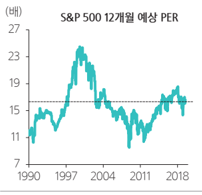

In [17]:
node = image_nodes[9]
print("TEXT:", node.text)
print("CAPTION:", node.caption)
node.image

(679, 281)
(690, 302)
(310, 111)
(310, 196)
(310, 198)
(310, 194)
(659, 249)
(658, 174)
(309, 175)
(309, 226)
(634, 247)
TEXT: <table><tbody><tr><th>구분</th><th colspan="2">시  간</th><th>내  용</th></tr><tr><td>1부</td><td>14:30~14:40</td><td>10&#x27;</td><td>•  인사말 (권용원 금융투자협회 회장)</td></tr><tr><td>14:40~15:40</td><td></td><td>60&#x27;</td><td>•  리서치센터장 (4인) 의 하반기 전망</td></tr><tr><td>-</td><td>15:40~15:45</td><td>5&#x27;</td><td>•  Break</td></tr><tr><td>2부</td><td>15:45~16:35</td><td>50&#x27;</td><td>•  종합토론 (센터장 4인, 운용사 2인, 연구원 1인)</td></tr></tbody></table>
CAPTION: 
TEXT: <table><tbody><tr><th>구분</th><th colspan="2">시  간</th><th>내  용</th></tr><tr><td>1부</td><td>14:30~14:40</td><td>10&#x27;</td><td>•  인사말 (권용원 금융투자협회 회장)</td></tr><tr><td>14:40~15:40</td><td></td><td>60&#x27;</td><td>•  리서치센터장 (4인) 의 하반기 전망</td></tr><tr><td>-</td><td>15:40~15:45</td><td>5&#x27;</td><td>•  Break</td></tr><tr><td>2부</td><td>15:45~16:35</td><td>50&#x27;</td><td>•  종합토론 (센터장 4인, 운용사 2인, 연구원 1인)</td></tr></tbod

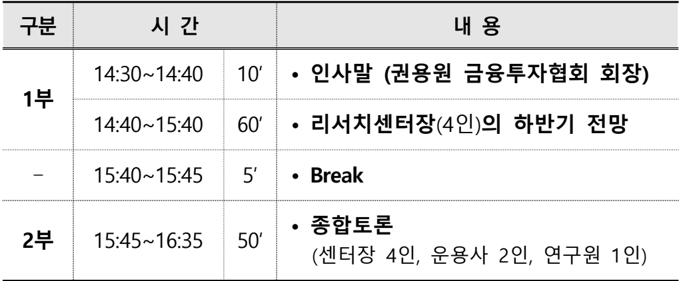

In [18]:
table_nodes = []
for node in document.nodes:
    if isinstance(node, TableNode):
        print(node.image.size)
        table_nodes.append(node)
        # break
node = table_nodes[0]
print("TEXT:", node.text)
print("CAPTION:", node.caption)
print("TEXT:", node.text)
node.image